In [ ]:
!pip install --upgrade tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Lấy file hàm hỗ trợ
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import chuỗi các hàm hỗ trợ cho notebook (chúng ta đã tạo)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-03-05 02:15:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-05 02:16:00 (94.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Dowload and preprocessing with 30% data

In [ ]:
setiment_csv = '/content/drive/MyDrive/semetic140.csv'
names = ['target', 'ids', 'date', 'query', 'user', 'text']
df = pd.read_csv(setiment_csv, names=names, encoding='ISO-8859-1')
df.head()

,target,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [ ]:
df_30_percent = df.sample(frac=0.3, random_state=42)
df_30_percent['target'].value_counts()

4    240639
0    239361
Name: target, dtype: int64

In [ ]:
sentences = np.array(df_30_percent['text'])
labels = np.array(df_30_percent['target'].apply(lambda x: 0 if x==0 else 1))

In [ ]:
sentences.shape, labels.shape

((480000,), (480000,))

# Split train and validation dataset

In [ ]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.05, random_state=42)

# Tokenization - Sequences, truncating and padding

In [ ]:
# # The length of the sentence accounts for 95% of the length
sentence_lens = [len(sentence.split()) for sentence in train_sentences]
max_len = int(np.percentile(sentence_lens,95))
max_len

25

In [ ]:
# Tokenizer 
OOV_TOKEN = '<OOV>'
tokenizer = Tokenizer(oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 291941 words

<OOV> token included in vocabulary


In [ ]:
# Sequence, padding and truncating
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_sequences = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')

print(f"Padded and truncated training sequences have shape: {train_sequences.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_sequences.shape}")

Padded and truncated training sequences have shape: (456000, 25)

Padded and truncated validation sequences have shape: (24000, 25)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_labels = tf.expand_dims(train_labels, -1)
val_labels = tf.expand_dims(val_labels, -1)
train_ds = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels)).shuffle(buffer_size=500000).batch(64).prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels)).batch(64).prefetch(AUTOTUNE)

# Define model

## Create callbacks

In [ ]:
# End training when model reaches 90% accuracy
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.90:
      print('\nReached 90% accuracy so cancelling training!')
      self.model.stop_training = True
on_epoch_end = myCallback()

# Stop training when val_loss doesn't improve after 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

## Model_0: Create embedding layer

In [ ]:
model_0 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_0.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
history_0 = model_0.fit(train_ds,
                        epochs=2,
                        validation_data=val_ds)

Epoch 1/2
7125/7125 [==============================] - 137s 19ms/step - loss: 0.4495 - accuracy: 0.7878 - val_loss: 0.4206 - val_accuracy: 0.8063
Epoch 2/2
7125/7125 [==============================] - 140s 20ms/step - loss: 0.2889 - accuracy: 0.8785 - val_loss: 0.4898 - val_accuracy: 0.7879


In [ ]:
model_0.evaluate(val_ds)

375/375 [==============================] - 1s 3ms/step - loss: 0.4898 - accuracy: 0.7879


[0.48978036642074585, 0.7878749966621399]

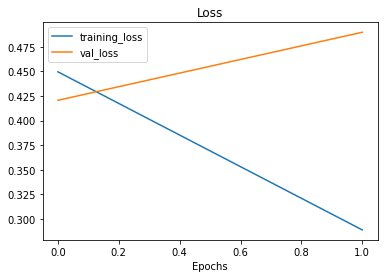

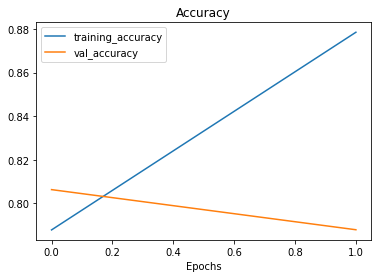

In [ ]:
plot_loss_curves(history_0)

## Model_1: using Bidirectional LSTM

In [ ]:
# Create checkpoint callback to save model progress
blstm_cp_path = '/content/drive/MyDrive/checkpoint_NLP/blstm_model/cp.ckpt'
blstm_cp_callback = tf.keras.callbacks.ModelCheckpoint(blstm_cp_path,
                                                       monitor='val_accuracy',
                                                       save_weights_only=True,
                                                       save_best_only=True)

In [ ]:
blstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=max_len),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

blstm_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
blstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 100)           29194100  
                                                                 
 bidirectional (Bidirectiona  (None, 25, 256)          234496    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)               

In [ ]:
blstm_history = blstm_model.fit(train_ds,
                                epochs=2,
                                validation_data=val_ds,
                                callbacks=[on_epoch_end, early_stopping, blstm_cp_callback])

Epoch 1/2
7125/7125 [==============================] - 222s 30ms/step - loss: 0.4365 - accuracy: 0.7969 - val_loss: 0.3975 - val_accuracy: 0.8208
Epoch 2/2
7125/7125 [==============================] - 216s 30ms/step - loss: 0.2715 - accuracy: 0.8876 - val_loss: 0.4678 - val_accuracy: 0.7915


In [ ]:
blstm_model.evaluate(val_ds)

375/375 [==============================] - 2s 6ms/step - loss: 0.4678 - accuracy: 0.7915


[0.467845618724823, 0.7914583086967468]

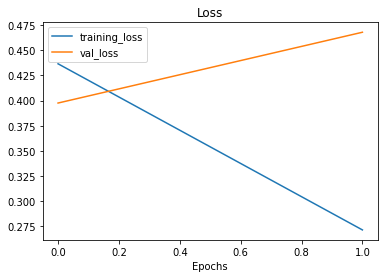

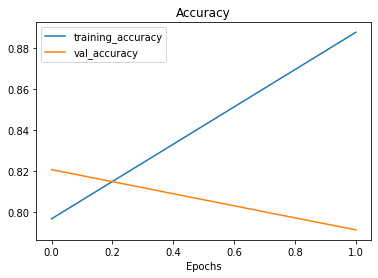

In [ ]:
plot_loss_curves(blstm_history)

## Model_2: Using pre-defined Embedding with Bidirectional LSTM

In [ ]:
GLOVE_FILE = '/content/drive/MyDrive/glove.6B.100d.txt'
GLOVE_EMBEDDING = {}

with open(GLOVE_FILE, 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    GLOVE_EMBEDDING[word] = coefs

In [ ]:
test_word = 'science'
test_vector = GLOVE_EMBEDDING[test_word]
print(test_vector)
print(f"Each word vector has shape: {test_vector.shape}")

[-0.13322   0.48858   0.18867   0.33791   0.54542  -0.69881   0.59954
 -0.40264  -0.26124   0.69962  -0.15999  -0.91523  -0.15415   0.60943
 -0.28774  -0.19603   0.69995   0.80869  -0.50221   0.46715  -0.53153
 -0.15619   0.30569  -0.67774   0.28715  -0.008962  0.65407  -0.47046
 -0.46508   0.2013   -1.3639    0.5951   -0.92377   0.24296  -0.81308
  0.058247 -0.94609   0.41951  -0.79614  -0.012944 -1.0193   -0.084872
 -1.537    -0.46909  -0.13942  -0.25741   0.17223   0.64303  -0.29022
  0.12509   0.53726  -0.42284   0.26365   0.46066  -0.075186 -1.8833
  0.73096   0.3121    1.4856    0.21834  -0.038657  0.89277  -0.30721
 -0.27414   0.74099   0.28438   0.034259  0.7253    0.79931   0.86114
  0.24113   0.68165   0.36753   0.15836  -1.2239    0.24132   0.42126
  0.050802 -1.0145   -0.21926  -0.38704   0.92132  -0.52473  -0.4821
 -1.4684    0.70665   0.033025 -0.46778   0.4284   -0.58346   0.78539
 -0.26193   0.25134   0.55163  -0.33975   0.32304   0.021859 -1.0756
  0.69851   0.18365 ]


In [ ]:
# Represent the words in our vocabulary using the embeddings
EMBEDDING_MATRIX = np.zeros((VOCAB_SIZE + 1, 100))
for word, index in word_index.items():
  embedding_vector = GLOVE_EMBEDDING.get(word)
  if embedding_vector is not None:
    EMBEDDING_MATRIX[index] = embedding_vector

In [ ]:
# Create checkpoint callback to save model progress
predefined_embedding_cp_path = '/content/drive/MyDrive/checkpoint_NLP/model_using_predefined_embedding/cp.ckpt'
predefined_embedding_cp_callback = tf.keras.callbacks.ModelCheckpoint(predefined_embedding_cp_path,
                                                                      monitor='val_accuracy',
                                                                      save_weights_only=True,
                                                                      save_best_only=True)

# Model
predefined_embedding_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE+1, 100, input_length=max_len, weights=[EMBEDDING_MATRIX], trainable=False),
    tf.keras.layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

predefined_embedding_model.compile(optimizer='adam',
                                   loss='binary_crossentropy',
                                   metrics=['accuracy'])
predefined_embedding_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 100)           29194200  
                                                                 
 bidirectional_2 (Bidirectio  (None, 25, 512)          731136    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 25, 256)          656384    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                      

In [ ]:
predefined_embedding_history = predefined_embedding_model.fit(train_ds,
                                                              epochs=30,
                                                              validation_data=val_ds,
                                                              callbacks=[on_epoch_end, early_stopping, predefined_embedding_cp_callback])

Epoch 1/30
7125/7125 [==============================] - 151s 20ms/step - loss: 0.4875 - accuracy: 0.7609 - val_loss: 0.4333 - val_accuracy: 0.8012
Epoch 2/30
7125/7125 [==============================] - 129s 18ms/step - loss: 0.4202 - accuracy: 0.8052 - val_loss: 0.4149 - val_accuracy: 0.8056
Epoch 3/30
7125/7125 [==============================] - 127s 18ms/step - loss: 0.3901 - accuracy: 0.8221 - val_loss: 0.3965 - val_accuracy: 0.8186
Epoch 4/30
7125/7125 [==============================] - 125s 17ms/step - loss: 0.3606 - accuracy: 0.8378 - val_loss: 0.4072 - val_accuracy: 0.8192
Epoch 5/30
7125/7125 [==============================] - 127s 18ms/step - loss: 0.3270 - accuracy: 0.8547 - val_loss: 0.4025 - val_accuracy: 0.8137
Epoch 6/30
7125/7125 [==============================] - 123s 17ms/step - loss: 0.2912 - accuracy: 0.8726 - val_loss: 0.4202 - val_accuracy: 0.8127


In [ ]:
predefined_embedding_model_results = predefined_embedding_model.evaluate(val_ds)
predefined_embedding_model_results

375/375 [==============================] - 4s 11ms/step - loss: 0.4202 - accuracy: 0.8127


[0.4202136993408203, 0.812666654586792]

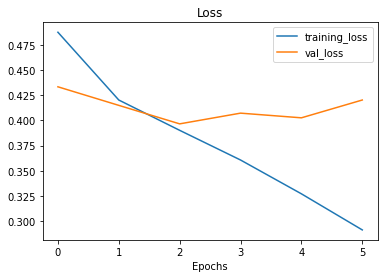

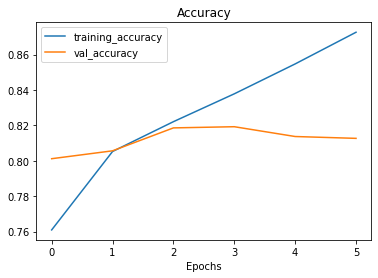

In [ ]:
plot_loss_curves(predefined_embedding_history)

In [ ]:
predefined_embedding_model.save("/content/drive/MyDrive/saved_model_NLP/predefined_embedding_model")

# Model_3: TensorFlow Hub Pretrained Sentence Encoder

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels)).shuffle(buffer_size=500000).batch(64).prefetch(AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels)).batch(64).prefetch(AUTOTUNE)

In [ ]:
# embedding đã huấn luyện trước với universal sentence encoder
import tensorflow_hub as hub 
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
                           input_shape=[], dtype=tf.string, trainable=False)

In [ ]:
# Model
nnlm_en_model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name='model_3_nnlm_en_dim128_normalization')
nnlm_en_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
nnlm_en_model.summary()

Model: "model_3_nnlm_en_dim128_normalization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_16 (Dense)            (None, 16)                2064      
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
# Create checkpoint callback to save model progress
nnlm_en_cp_path = '/content/drive/MyDrive/checkpoint_NLP/model_nnlm_en_dim128_normalization/cp.ckpt'
nnlm_en_cp = tf.keras.callbacks.ModelCheckpoint(nnlm_en_cp_path,
                                                monitor='val_accuracy',
                                                save_weights_only=True,
                                                save_best_only=True)
nnlm_en_history = nnlm_en_model.fit(train_dataset,
                                    epochs=30,
                                    validation_data=val_dataset,
                                    callbacks=[on_epoch_end, early_stopping, nnlm_en_cp])

Epoch 1/30
7125/7125 [==============================] - 46s 6ms/step - loss: 0.5421 - accuracy: 0.7257 - val_loss: 0.5326 - val_accuracy: 0.7327
Epoch 2/30
7125/7125 [==============================] - 41s 6ms/step - loss: 0.5270 - accuracy: 0.7361 - val_loss: 0.5210 - val_accuracy: 0.7417
Epoch 3/30
7125/7125 [==============================] - 41s 6ms/step - loss: 0.5200 - accuracy: 0.7411 - val_loss: 0.5160 - val_accuracy: 0.7444
Epoch 4/30
7125/7125 [==============================] - 43s 6ms/step - loss: 0.5156 - accuracy: 0.7443 - val_loss: 0.5155 - val_accuracy: 0.7444
Epoch 5/30
7125/7125 [==============================] - 45s 6ms/step - loss: 0.5129 - accuracy: 0.7460 - val_loss: 0.5109 - val_accuracy: 0.7471
Epoch 6/30
7125/7125 [==============================] - 41s 6ms/step - loss: 0.5113 - accuracy: 0.7470 - val_loss: 0.5096 - val_accuracy: 0.7488
Epoch 7/30
7125/7125 [==============================] - 40s 5ms/step - loss: 0.5100 - accuracy: 0.7475 - val_loss: 0.5098 - val_ac

In [ ]:
nnlm_en_model_results = nnlm_en_model.evaluate(val_dataset)
nnlm_en_model_results

375/375 [==============================] - 2s 5ms/step - loss: 0.5057 - accuracy: 0.7518


[0.5057478547096252, 0.7518333196640015]

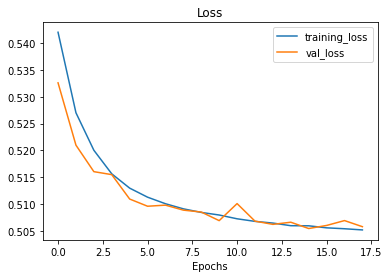

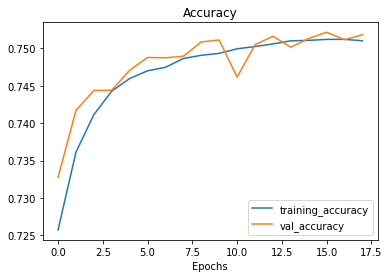

In [ ]:
plot_loss_curves(nnlm_en_history)

In [ ]:
nnlm_en_model.save("/content/drive/MyDrive/saved_model_NLP/nnlm_en_model")

# Tìm mẫu sai nhất

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/saved_model_NLP/nnlm_en_model")

In [ ]:
model.summary()

Model: "model_3_nnlm_en_dim128_normalization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_16 (Dense)            (None, 16)                2064      
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________


In [ ]:
pred_probs = model.predict(val_sentences)

750/750 [==============================] - 2s 3ms/step


In [ ]:
pred = []
for prob in pred_probs:
  if prob > 0.5:
    pred.append(1)
  else: pred.append(0)  
pred[:10]


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import f1_score
f1_score(val_labels, pred)

0.7506906655504395